In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from typing import Any, Dict, Optional

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
from arviz import r2_score

from causalpy.utils import round_num


class PyMCModel(pm.Model):
    """A wrapper class for PyMC models. This provides a scikit-learn like interface with
    methods like `fit`, `predict`, and `score`. It also provides other methods which are
    useful for causal inference.

    Example
    -------
    >>> import causalpy as cp
    >>> import numpy as np
    >>> import pymc as pm
    >>> from causalpy.pymc_models import PyMCModel
    >>> class MyToyModel(PyMCModel):
    ...     def build_model(self, X, y, coords):
    ...         with self:
    ...             X_ = pm.Data(name="X", value=X)
    ...             y_ = pm.Data(name="y", value=y)
    ...             beta = pm.Normal("beta", mu=0, sigma=1, shape=X_.shape[1])
    ...             sigma = pm.HalfNormal("sigma", sigma=1)
    ...             mu = pm.Deterministic("mu", pm.math.dot(X_, beta))
    ...             pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_)
    >>> rng = np.random.default_rng(seed=42)
    >>> X = rng.normal(loc=0, scale=1, size=(20, 2))
    >>> y = rng.normal(loc=0, scale=1, size=(20,))
    >>> model = MyToyModel(
    ...     sample_kwargs={
    ...         "chains": 2,
    ...         "draws": 2000,
    ...         "progressbar": False,
    ...         "random_seed": 42,
    ...     }
    ... )
    >>> model.fit(X, y)
    Inference data...
    >>> model.score(X, y)  # doctest: +ELLIPSIS
    r2        ...
    r2_std    ...
    dtype: float64
    >>> X_new = rng.normal(loc=0, scale=1, size=(20, 2))
    >>> model.predict(X_new)
    Inference data...
    """

    def __init__(self, sample_kwargs: Optional[Dict[str, Any]] = None):
        """
        :param sample_kwargs: A dictionary of kwargs that get unpacked and passed to the
            :func:`pymc.sample` function. Defaults to an empty dictionary.
        """
        super().__init__()
        self.idata = None
        self.sample_kwargs = sample_kwargs if sample_kwargs is not None else {}

    def build_model(self, X, y, coords) -> None:
        """Build the model, must be implemented by subclass."""
        raise NotImplementedError("This method must be implemented by a subclass")

    def _data_setter(self, X) -> None:
        """
        Set data for the model.

        This method is used internally to register new data for the model for
        prediction.
        """
        with self:
            pm.set_data({"X": X})

    def fit(self, X, y, coords: Optional[Dict[str, Any]] = None) -> None:
        """Draw samples from posterior, prior predictive, and posterior predictive
        distributions, placing them in the model's idata attribute.
        """

        # Ensure random_seed is used in sample_prior_predictive() and
        # sample_posterior_predictive() if provided in sample_kwargs.
        random_seed = self.sample_kwargs.get("random_seed", None)

        self.build_model(X, y, coords)
        with self:
            self.idata = pm.sample(**self.sample_kwargs)
            self.idata.extend(pm.sample_prior_predictive(random_seed=random_seed))
            self.idata.extend(
                pm.sample_posterior_predictive(
                    self.idata, progressbar=False, random_seed=random_seed
                )
            )
        return self.idata

    def predict(self, X):
        """
        Predict data given input data `X`

        .. caution::
            Results in KeyError if model hasn't been fit.

        """

        # Ensure random_seed is used in sample_prior_predictive() and
        # sample_posterior_predictive() if provided in sample_kwargs.
        random_seed = self.sample_kwargs.get("random_seed", None)
        self._data_setter(X)
        with self:  # sample with new input data
            post_pred = pm.sample_posterior_predictive(
                self.idata,
                var_names=["y_hat", "mu"],
                progressbar=False,
                random_seed=random_seed,
            )
        return post_pred

    def score(self, X, y) -> pd.Series:
        """Score the Bayesian :math:`R^2` given inputs ``X`` and outputs ``y``.

        Note that the score is based on a comparison of the observed data ``y`` and the
        model's expected value of the data, `mu`.

        .. caution::

            The Bayesian :math:`R^2` is not the same as the traditional coefficient of
            determination, https://en.wikipedia.org/wiki/Coefficient_of_determination.

        """
        mu = self.predict(X)
        mu = az.extract(mu, group="posterior_predictive", var_names="mu").T.values
        # Note: First argument must be a 1D array
        return r2_score(y.flatten(), mu)

    def calculate_impact(self, y_true, y_pred):
        pre_data = xr.DataArray(y_true, dims=["obs_ind"])
        impact = pre_data - y_pred["posterior_predictive"]["y_hat"]
        return impact.transpose(..., "obs_ind")

    def calculate_cumulative_impact(self, impact):
        return impact.cumsum(dim="obs_ind")

    def print_coefficients(self, labels, round_to=None) -> None:
        def print_row(
            max_label_length: int, name: str, coeff_samples: xr.DataArray, round_to: int
        ) -> None:
            """Print one row of the coefficient table"""
            formatted_name = f"  {name: <{max_label_length}}"
            formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"  # noqa: E501
            print(f"  {formatted_name}  {formatted_val}")

        print("Model coefficients:")
        coeffs = az.extract(self.idata.posterior, var_names="beta")

        # Determine the width of the longest label
        max_label_length = max(len(name) for name in labels + ["sigma"])

        for name in labels:
            coeff_samples = coeffs.sel(coeffs=name)
            print_row(max_label_length, name, coeff_samples, round_to)

        # Add coefficient for measurement std
        coeff_samples = az.extract(self.idata.posterior, var_names="sigma")
        name = "sigma"
        print_row(max_label_length, name, coeff_samples, round_to)


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
class WeightedSumFitter(PyMCModel):
    r"""
    Used for synthetic control experiments.

    Defines the PyMC model:

    .. math::
        \sigma &\sim \mathrm{HalfNormal}(1) \\
        \beta &\sim \mathrm{Dirichlet}(1,...,1) \\
        \mu &= X \cdot \beta \\
        y &\sim \mathrm{Normal}(\mu, \sigma) \\

    Example
    --------
    >>> import causalpy as cp
    >>> import numpy as np
    >>> from causalpy.pymc_models import WeightedSumFitter
    >>> sc = cp.load_data("sc")
    >>> X = sc[['a', 'b', 'c', 'd', 'e', 'f', 'g']]
    >>> y = np.asarray(sc['actual']).reshape((sc.shape[0], 1))
    >>> wsf = WeightedSumFitter(sample_kwargs={"progressbar": False})
    >>> wsf.fit(X,y)
    Inference data...
    """  # noqa: W605

    def build_model(self, X, y, coords):
        """
        Defines the PyMC model
        """
        with self:
            self.add_coords(coords)
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            # TODO: There we should allow user-specified priors here
            beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
            # beta = pm.Dirichlet(
            #     name="beta", a=(1 / n_predictors) * np.ones(n_predictors),
            #     dims="coeffs"
            # )
            sigma = pm.HalfNormal("sigma", 1)
            mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [4]:
from abc import abstractmethod

from sklearn.base import RegressorMixin

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [5]:
class BaseExperiment:
    """Base class for quasi experimental designs."""

    supports_bayes: bool
    supports_ols: bool

    def __init__(self, model=None):

        if model is not None:
            self.model = model

        if isinstance(self.model, PyMCModel) and not self.supports_bayes:
            raise ValueError("Bayesian models not supported.")

        if isinstance(self.model, RegressorMixin) and not self.supports_ols:
            raise ValueError("OLS models not supported.")

        if self.model is None:
            raise ValueError("model not set or passed.")

    @property
    def idata(self):
        """Return the InferenceData object of the model. Only relevant for PyMC models."""
        return self.model.idata

    def print_coefficients(self, round_to=None):
        """Ask the model to print its coefficients."""
        self.model.print_coefficients(self.labels, round_to)

    def plot(self, *args, **kwargs) -> tuple:
        """Plot the model.

        Internally, this function dispatches to either `bayesian_plot` or `ols_plot`
        depending on the model type.
        """
        if isinstance(self.model, PyMCModel):
            return self.bayesian_plot(*args, **kwargs)
        elif isinstance(self.model, RegressorMixin):
            return self.ols_plot(*args, **kwargs)
        else:
            raise ValueError("Unsupported model type")

    @abstractmethod
    def bayesian_plot(self, *args, **kwargs):
        """Abstract method for plotting the model."""
        raise NotImplementedError("bayesian_plot method not yet implemented")

    @abstractmethod
    def ols_plot(self, *args, **kwargs):
        """Abstract method for plotting the model."""
        raise NotImplementedError("ols_plot method not yet implemented")

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [6]:
from typing import List, Union

import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from patsy import build_design_matrices, dmatrices
from sklearn.base import RegressorMixin

from causalpy.custom_exceptions import BadIndexException
from causalpy.plot_utils import plot_xY
from causalpy.pymc_models import PyMCModel
from causalpy.utils import round_num

LEGEND_FONT_SIZE = 12


class PrePostFit(BaseExperiment):
    """
    A base class for quasi-experimental designs where parameter estimation is based on
    just pre-intervention data. This class is not directly invoked by the user.
    """

    def __init__(
        self,
        data: pd.DataFrame,
        treatment_time: Union[int, float, pd.Timestamp],
        formula: str,
        model=None,
        **kwargs,
    ) -> None:
        super().__init__(model=model)
        self.input_validation(data, treatment_time)
        self.treatment_time = treatment_time
        # set experiment type - usually done in subclasses
        self.expt_type = "Pre-Post Fit"
        # split data in to pre and post intervention
        self.datapre = data[data.index < self.treatment_time]
        self.datapost = data[data.index >= self.treatment_time]

        self.formula = formula

        # set things up with pre-intervention data
        y, X = dmatrices(formula, self.datapre)
        self.outcome_variable_name = y.design_info.column_names[0]
        self._y_design_info = y.design_info
        self._x_design_info = X.design_info
        self.labels = X.design_info.column_names
        self.pre_y, self.pre_X = np.asarray(y), np.asarray(X)
        # process post-intervention data
        (new_y, new_x) = build_design_matrices(
            [self._y_design_info, self._x_design_info], self.datapost
        )
        self.post_X = np.asarray(new_x)
        self.post_y = np.asarray(new_y)

        # fit the model to the observed (pre-intervention) data
        if isinstance(self.model, PyMCModel):
            COORDS = {"coeffs": self.labels, "obs_indx": np.arange(self.pre_X.shape[0])}
            self.model.fit(X=self.pre_X, y=self.pre_y, coords=COORDS)
        elif isinstance(self.model, RegressorMixin):
            self.model.fit(X=self.pre_X, y=self.pre_y)
        else:
            raise ValueError("Model type not recognized")

        # score the goodness of fit to the pre-intervention data
        self.score = self.model.score(X=self.pre_X, y=self.pre_y)

        # get the model predictions of the observed (pre-intervention) data
        self.pre_pred = self.model.predict(X=self.pre_X)

        # calculate the counterfactual
        self.post_pred = self.model.predict(X=self.post_X)
        self.pre_impact = self.model.calculate_impact(self.pre_y[:, 0], self.pre_pred)
        self.post_impact = self.model.calculate_impact(
            self.post_y[:, 0], self.post_pred
        )
        self.post_impact_cumulative = self.model.calculate_cumulative_impact(
            self.post_impact
        )

    def input_validation(self, data, treatment_time):
        """Validate the input data and model formula for correctness"""
        if isinstance(data.index, pd.DatetimeIndex) and not isinstance(
            treatment_time, pd.Timestamp
        ):
            raise BadIndexException(
                "If data.index is DatetimeIndex, treatment_time must be pd.Timestamp."
            )
        if not isinstance(data.index, pd.DatetimeIndex) and isinstance(
            treatment_time, pd.Timestamp
        ):
            raise BadIndexException(
                "If data.index is not DatetimeIndex, treatment_time must be pd.Timestamp."  # noqa: E501
            )

    def summary(self, round_to=None) -> None:
        """Print summary of main results and model coefficients.

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to return raw numbers
        """
        print(f"{self.expt_type:=^80}")
        print(f"Formula: {self.formula}")
        self.print_coefficients(round_to)

    def bayesian_plot(
        self, round_to=None, **kwargs
    ) -> tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot the results

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to return raw numbers.
        """
        counterfactual_label = "Counterfactual"

        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 8))
        # TOP PLOT --------------------------------------------------
        # pre-intervention period
        h_line, h_patch = plot_xY(
            self.datapre.index,
            self.pre_pred["posterior_predictive"].mu,
            ax=ax[0],
            plot_hdi_kwargs={"color": "C0"},
        )
        handles = [(h_line, h_patch)]
        labels = ["Pre-intervention period"]

        (h,) = ax[0].plot(self.datapre.index, self.pre_y, "k.", label="Observations")
        handles.append(h)
        labels.append("Observations")

        # post intervention period
        h_line, h_patch = plot_xY(
            self.datapost.index,
            self.post_pred["posterior_predictive"].mu,
            ax=ax[0],
            plot_hdi_kwargs={"color": "C1"},
        )
        handles.append((h_line, h_patch))
        labels.append(counterfactual_label)

        ax[0].plot(self.datapost.index, self.post_y, "k.")
        # Shaded causal effect
        h = ax[0].fill_between(
            self.datapost.index,
            y1=az.extract(
                self.post_pred, group="posterior_predictive", var_names="mu"
            ).mean("sample"),
            y2=np.squeeze(self.post_y),
            color="C0",
            alpha=0.25,
        )
        handles.append(h)
        labels.append("Causal impact")

        ax[0].set(
            title=f"""
            Pre-intervention Bayesian $R^2$: {round_num(self.score.r2, round_to)}
            (std = {round_num(self.score.r2_std, round_to)})
            """
        )

        # MIDDLE PLOT -----------------------------------------------
        plot_xY(
            self.datapre.index,
            self.pre_impact,
            ax=ax[1],
            plot_hdi_kwargs={"color": "C0"},
        )
        plot_xY(
            self.datapost.index,
            self.post_impact,
            ax=ax[1],
            plot_hdi_kwargs={"color": "C1"},
        )
        ax[1].axhline(y=0, c="k")
        ax[1].fill_between(
            self.datapost.index,
            y1=self.post_impact.mean(["chain", "draw"]),
            color="C0",
            alpha=0.25,
            label="Causal impact",
        )
        ax[1].set(title="Causal Impact")

        # BOTTOM PLOT -----------------------------------------------
        ax[2].set(title="Cumulative Causal Impact")
        plot_xY(
            self.datapost.index,
            self.post_impact_cumulative,
            ax=ax[2],
            plot_hdi_kwargs={"color": "C1"},
        )
        ax[2].axhline(y=0, c="k")

        # Intervention line
        for i in [0, 1, 2]:
            ax[i].axvline(
                x=self.treatment_time,
                ls="-",
                lw=3,
                color="r",
            )

        ax[0].legend(
            handles=(h_tuple for h_tuple in handles),
            labels=labels,
            fontsize=LEGEND_FONT_SIZE,
        )

        return fig, ax

    def ols_plot(self, round_to=None, **kwargs) -> tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot the results

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to return raw numbers.
        """
        counterfactual_label = "Counterfactual"

        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 8))

        ax[0].plot(self.datapre.index, self.pre_y, "k.")
        ax[0].plot(self.datapost.index, self.post_y, "k.")

        ax[0].plot(self.datapre.index, self.pre_pred, c="k", label="model fit")
        ax[0].plot(
            self.datapost.index,
            self.post_pred,
            label=counterfactual_label,
            ls=":",
            c="k",
        )
        ax[0].set(
            title=f"$R^2$ on pre-intervention data = {round_num(self.score, round_to)}"
        )

        ax[1].plot(self.datapre.index, self.pre_impact, "k.")
        ax[1].plot(
            self.datapost.index,
            self.post_impact,
            "k.",
            label=counterfactual_label,
        )
        ax[1].axhline(y=0, c="k")
        ax[1].set(title="Causal Impact")

        ax[2].plot(self.datapost.index, self.post_impact_cumulative, c="k")
        ax[2].axhline(y=0, c="k")
        ax[2].set(title="Cumulative Causal Impact")

        # Shaded causal effect
        ax[0].fill_between(
            self.datapost.index,
            y1=np.squeeze(self.post_pred),
            y2=np.squeeze(self.post_y),
            color="C0",
            alpha=0.25,
            label="Causal impact",
        )
        ax[1].fill_between(
            self.datapost.index,
            y1=np.squeeze(self.post_impact),
            color="C0",
            alpha=0.25,
            label="Causal impact",
        )

        # Intervention line
        # TODO: make this work when treatment_time is a datetime
        for i in [0, 1, 2]:
            ax[i].axvline(
                x=self.treatment_time,
                ls="-",
                lw=3,
                color="r",
                label="Treatment time",
            )

        ax[0].legend(fontsize=LEGEND_FONT_SIZE)

        return (fig, ax)


/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [7]:
from typing import List, Union

import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from patsy import build_design_matrices, dmatrices
from sklearn.base import RegressorMixin

from causalpy.custom_exceptions import BadIndexException
from causalpy.plot_utils import plot_xY
from causalpy.pymc_models import PyMCModel
from causalpy.utils import round_num


LEGEND_FONT_SIZE = 12


class PrePostFit(BaseExperiment):
    """
    A base class for quasi-experimental designs where parameter estimation is based on
    just pre-intervention data. This class is not directly invoked by the user.
    """

    def __init__(
        self,
        data: pd.DataFrame,
        treatment_time: Union[int, float, pd.Timestamp],
        formula: str,
        model=None,
        **kwargs,
    ) -> None:
        super().__init__(model=model)
        self.input_validation(data, treatment_time)
        self.treatment_time = treatment_time
        # set experiment type - usually done in subclasses
        self.expt_type = "Pre-Post Fit"
        # split data in to pre and post intervention
        self.datapre = data[data.index < self.treatment_time]
        self.datapost = data[data.index >= self.treatment_time]

        self.formula = formula

        # set things up with pre-intervention data
        y, X = dmatrices(formula, self.datapre)
        self.outcome_variable_name = y.design_info.column_names[0]
        self._y_design_info = y.design_info
        self._x_design_info = X.design_info
        self.labels = X.design_info.column_names
        self.pre_y, self.pre_X = np.asarray(y), np.asarray(X)
        # process post-intervention data
        (new_y, new_x) = build_design_matrices(
            [self._y_design_info, self._x_design_info], self.datapost
        )
        self.post_X = np.asarray(new_x)
        self.post_y = np.asarray(new_y)

        # fit the model to the observed (pre-intervention) data
        if isinstance(self.model, PyMCModel):
            COORDS = {"coeffs": self.labels, "obs_indx": np.arange(self.pre_X.shape[0])}
            self.model.fit(X=self.pre_X, y=self.pre_y, coords=COORDS)
        elif isinstance(self.model, RegressorMixin):
            self.model.fit(X=self.pre_X, y=self.pre_y)
        else:
            raise ValueError("Model type not recognized")

        # score the goodness of fit to the pre-intervention data
        self.score = self.model.score(X=self.pre_X, y=self.pre_y)

        # get the model predictions of the observed (pre-intervention) data
        self.pre_pred = self.model.predict(X=self.pre_X)

        # calculate the counterfactual
        self.post_pred = self.model.predict(X=self.post_X)
        self.pre_impact = self.model.calculate_impact(self.pre_y[:, 0], self.pre_pred)
        self.post_impact = self.model.calculate_impact(
            self.post_y[:, 0], self.post_pred
        )
        self.post_impact_cumulative = self.model.calculate_cumulative_impact(
            self.post_impact
        )

    def input_validation(self, data, treatment_time):
        """Validate the input data and model formula for correctness"""
        if isinstance(data.index, pd.DatetimeIndex) and not isinstance(
            treatment_time, pd.Timestamp
        ):
            raise BadIndexException(
                "If data.index is DatetimeIndex, treatment_time must be pd.Timestamp."
            )
        if not isinstance(data.index, pd.DatetimeIndex) and isinstance(
            treatment_time, pd.Timestamp
        ):
            raise BadIndexException(
                "If data.index is not DatetimeIndex, treatment_time must be pd.Timestamp."  # noqa: E501
            )

    def summary(self, round_to=None) -> None:
        """Print summary of main results and model coefficients.

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to return raw numbers
        """
        print(f"{self.expt_type:=^80}")
        print(f"Formula: {self.formula}")
        self.print_coefficients(round_to)

    def bayesian_plot(
        self, round_to=None, **kwargs
    ) -> tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot the results

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to return raw numbers.
        """
        counterfactual_label = "Counterfactual"

        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 8))
        # TOP PLOT --------------------------------------------------
        # pre-intervention period
        h_line, h_patch = plot_xY(
            self.datapre.index,
            self.pre_pred["posterior_predictive"].mu,
            ax=ax[0],
            plot_hdi_kwargs={"color": "C0"},
        )
        handles = [(h_line, h_patch)]
        labels = ["Pre-intervention period"]

        (h,) = ax[0].plot(self.datapre.index, self.pre_y, "k.", label="Observations")
        handles.append(h)
        labels.append("Observations")

        # post intervention period
        h_line, h_patch = plot_xY(
            self.datapost.index,
            self.post_pred["posterior_predictive"].mu,
            ax=ax[0],
            plot_hdi_kwargs={"color": "C1"},
        )
        handles.append((h_line, h_patch))
        labels.append(counterfactual_label)

        ax[0].plot(self.datapost.index, self.post_y, "k.")
        # Shaded causal effect
        h = ax[0].fill_between(
            self.datapost.index,
            y1=az.extract(
                self.post_pred, group="posterior_predictive", var_names="mu"
            ).mean("sample"),
            y2=np.squeeze(self.post_y),
            color="C0",
            alpha=0.25,
        )
        handles.append(h)
        labels.append("Causal impact")

        ax[0].set(
            title=f"""
            Pre-intervention Bayesian $R^2$: {round_num(self.score.r2, round_to)}
            (std = {round_num(self.score.r2_std, round_to)})
            """
        )

        # MIDDLE PLOT -----------------------------------------------
        plot_xY(
            self.datapre.index,
            self.pre_impact,
            ax=ax[1],
            plot_hdi_kwargs={"color": "C0"},
        )
        plot_xY(
            self.datapost.index,
            self.post_impact,
            ax=ax[1],
            plot_hdi_kwargs={"color": "C1"},
        )
        ax[1].axhline(y=0, c="k")
        ax[1].fill_between(
            self.datapost.index,
            y1=self.post_impact.mean(["chain", "draw"]),
            color="C0",
            alpha=0.25,
            label="Causal impact",
        )
        ax[1].set(title="Causal Impact")

        # BOTTOM PLOT -----------------------------------------------
        ax[2].set(title="Cumulative Causal Impact")
        plot_xY(
            self.datapost.index,
            self.post_impact_cumulative,
            ax=ax[2],
            plot_hdi_kwargs={"color": "C1"},
        )
        ax[2].axhline(y=0, c="k")

        # Intervention line
        for i in [0, 1, 2]:
            ax[i].axvline(
                x=self.treatment_time,
                ls="-",
                lw=3,
                color="r",
            )

        ax[0].legend(
            handles=(h_tuple for h_tuple in handles),
            labels=labels,
            fontsize=LEGEND_FONT_SIZE,
        )

        return fig, ax

    def ols_plot(self, round_to=None, **kwargs) -> tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot the results

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to return raw numbers.
        """
        counterfactual_label = "Counterfactual"

        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 8))

        ax[0].plot(self.datapre.index, self.pre_y, "k.")
        ax[0].plot(self.datapost.index, self.post_y, "k.")

        ax[0].plot(self.datapre.index, self.pre_pred, c="k", label="model fit")
        ax[0].plot(
            self.datapost.index,
            self.post_pred,
            label=counterfactual_label,
            ls=":",
            c="k",
        )
        ax[0].set(
            title=f"$R^2$ on pre-intervention data = {round_num(self.score, round_to)}"
        )

        ax[1].plot(self.datapre.index, self.pre_impact, "k.")
        ax[1].plot(
            self.datapost.index,
            self.post_impact,
            "k.",
            label=counterfactual_label,
        )
        ax[1].axhline(y=0, c="k")
        ax[1].set(title="Causal Impact")

        ax[2].plot(self.datapost.index, self.post_impact_cumulative, c="k")
        ax[2].axhline(y=0, c="k")
        ax[2].set(title="Cumulative Causal Impact")

        # Shaded causal effect
        ax[0].fill_between(
            self.datapost.index,
            y1=np.squeeze(self.post_pred),
            y2=np.squeeze(self.post_y),
            color="C0",
            alpha=0.25,
            label="Causal impact",
        )
        ax[1].fill_between(
            self.datapost.index,
            y1=np.squeeze(self.post_impact),
            color="C0",
            alpha=0.25,
            label="Causal impact",
        )

        # Intervention line
        # TODO: make this work when treatment_time is a datetime
        for i in [0, 1, 2]:
            ax[i].axvline(
                x=self.treatment_time,
                ls="-",
                lw=3,
                color="r",
                label="Treatment time",
            )

        ax[0].legend(fontsize=LEGEND_FONT_SIZE)

        return (fig, ax)

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [8]:
class SyntheticControl(PrePostFit):
    """A wrapper around the PrePostFit class

    :param data:
        A pandas dataframe
    :param treatment_time:
        The time when treatment occurred, should be in reference to the data index
    :param formula:
        A statistical model formula
    :param model:
        A PyMC model

    Example
    --------
    >>> import causalpy as cp
    >>> df = cp.load_data("sc")
    >>> treatment_time = 70
    >>> seed = 42
    >>> result = cp.SyntheticControl(
    ...     df,
    ...     treatment_time,
    ...     formula="actual ~ 0 + a + b + c + d + e + f + g",
    ...     model=cp.pymc_models.WeightedSumFitter(
    ...         sample_kwargs={
    ...             "target_accept": 0.95,
    ...             "random_seed": seed,
    ...             "progressbar": False,
    ...         }
    ...     ),
    ... )
    """

    expt_type = "SyntheticControl"
    supports_ols = True
    supports_bayes = True

    def bayesian_plot(self, *args, **kwargs) -> tuple[plt.Figure, List[plt.Axes]]:
        """
        Plot the results

        :param round_to:
            Number of decimals used to round results. Defaults to 2. Use "None" to
            return raw numbers.
        :param plot_predictors:
            Whether to plot the control units as well. Defaults to False.
        """
        # call the super class method
        fig, ax = super().bayesian_plot(*args, **kwargs)

        # additional plotting functionality for the synthetic control experiment
        plot_predictors = kwargs.get("plot_predictors", False)
        if plot_predictors:
            # plot control units as well
            ax[0].plot(self.datapre.index, self.pre_X, "-", c=[0.8, 0.8, 0.8], zorder=1)
            ax[0].plot(
                self.datapost.index, self.post_X, "-", c=[0.8, 0.8, 0.8], zorder=1
            )

        return fig, ax

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [9]:
import pandas as pd

df = pd.read_parquet('data_causal.pt')
T0 = 50

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


In [10]:
seed = 42

result = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 0 + a + b + c + d + e + f + g + h + i", #без константы
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:232: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  language = self._parent_header['metadata'].get('language')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:237: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  livy = self._parent_header['metadata'].get('livy')
/kernel/lib/python3.10/site-packages/ml_kernel/kernel.py:280: DeprecationWarning: Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  header = self._parent_header['header']


ValueError: Model type not recognized

In [14]:
import warnings
warnings.filterwarnings('ignore')

from typing import Any, Dict, Optional
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
from arviz import r2_score
from sklearn.base import RegressorMixin

# Сначала определим базовый класс PyMCModel
class PyMCModel(pm.Model):
    def __init__(self, sample_kwargs: Optional[Dict[str, Any]] = None):
        super().__init__()
        self.idata = None
        self.sample_kwargs = sample_kwargs if sample_kwargs is not None else {}

    def build_model(self, X, y, coords) -> None:
        raise NotImplementedError("This method must be implemented by a subclass")

    def _data_setter(self, X) -> None:
        with self:
            pm.set_data({"X": X})

    def fit(self, X, y, coords: Optional[Dict[str, Any]] = None) -> None:
        random_seed = self.sample_kwargs.get("random_seed", None)
        self.build_model(X, y, coords)
        with self:
            self.idata = pm.sample(**self.sample_kwargs)
            self.idata.extend(pm.sample_prior_predictive(random_seed=random_seed))
            self.idata.extend(
                pm.sample_posterior_predictive(
                    self.idata, progressbar=False, random_seed=random_seed
                )
            )
        return self.idata

    def predict(self, X):
        random_seed = self.sample_kwargs.get("random_seed", None)
        self._data_setter(X)
        with self:
            post_pred = pm.sample_posterior_predictive(
                self.idata,
                var_names=["y_hat", "mu"],
                progressbar=False,
                random_seed=random_seed,
            )
        return post_pred

    def score(self, X, y) -> pd.Series:
        mu = self.predict(X)
        mu = az.extract(mu, group="posterior_predictive", var_names="mu").T.values
        return r2_score(y.flatten(), mu)

    def calculate_impact(self, y_true, y_pred):
        pre_data = xr.DataArray(y_true, dims=["obs_ind"])
        impact = pre_data - y_pred["posterior_predictive"]["y_hat"]
        return impact.transpose(..., "obs_ind")

    def calculate_cumulative_impact(self, impact):
        return impact.cumsum(dim="obs_ind")

# Затем определим WeightedSumFitter
class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
            sigma = pm.HalfNormal("sigma", 1)
            mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

# Теперь можно использовать код
import pandas as pd
df = pd.read_parquet('data_causal.pt')
T0 = 50
seed = 42

result = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i", #без константы
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


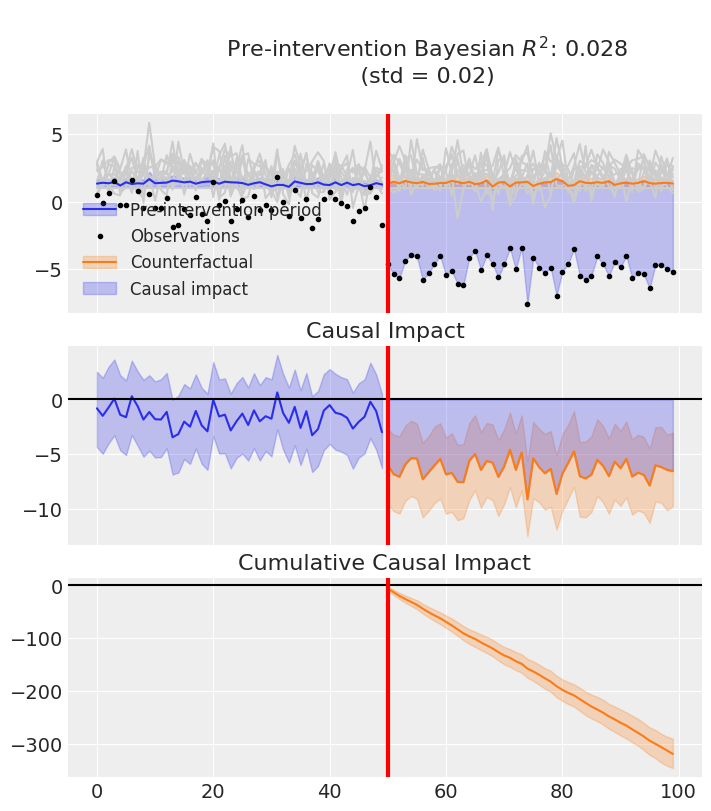

In [15]:
fig, ax = result.plot(plot_predictors=True)

In [16]:
import arviz as az
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-6.372,0.297,-6.905,-5.795,0.005,0.004,3543.0,3656.0,1.0


In [19]:
import warnings
warnings.filterwarnings('ignore')

from typing import Any, Dict, Optional
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
from arviz import r2_score
from sklearn.base import RegressorMixin

# Сначала определим базовый класс PyMCModel
class PyMCModel(pm.Model):
    def __init__(self, sample_kwargs: Optional[Dict[str, Any]] = None):
        super().__init__()
        self.idata = None
        self.sample_kwargs = sample_kwargs if sample_kwargs is not None else {}

    def build_model(self, X, y, coords) -> None:
        raise NotImplementedError("This method must be implemented by a subclass")

    def _data_setter(self, X) -> None:
        with self:
            pm.set_data({"X": X})

    def fit(self, X, y, coords: Optional[Dict[str, Any]] = None) -> None:
        random_seed = self.sample_kwargs.get("random_seed", None)
        self.build_model(X, y, coords)
        with self:
            self.idata = pm.sample(**self.sample_kwargs)
            self.idata.extend(pm.sample_prior_predictive(random_seed=random_seed))
            self.idata.extend(
                pm.sample_posterior_predictive(
                    self.idata, progressbar=False, random_seed=random_seed
                )
            )
        return self.idata

    def predict(self, X):
        random_seed = self.sample_kwargs.get("random_seed", None)
        self._data_setter(X)
        with self:
            post_pred = pm.sample_posterior_predictive(
                self.idata,
                var_names=["y_hat", "mu"],
                progressbar=False,
                random_seed=random_seed,
            )
        return post_pred

    def score(self, X, y) -> pd.Series:
        mu = self.predict(X)
        mu = az.extract(mu, group="posterior_predictive", var_names="mu").T.values
        return r2_score(y.flatten(), mu)

    def calculate_impact(self, y_true, y_pred):
        pre_data = xr.DataArray(y_true, dims=["obs_ind"])
        impact = pre_data - y_pred["posterior_predictive"]["y_hat"]
        return impact.transpose(..., "obs_ind")

    def calculate_cumulative_impact(self, impact):
        return impact.cumsum(dim="obs_ind")

# Затем определим WeightedSumFitter
class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            
            # Отдельно обрабатываем константу и остальные предикторы
            intercept = pm.Normal("intercept", mu=0, sigma=1)
            beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
            
            sigma = pm.HalfNormal("sigma", 1)
            
            # Вычисляем mu с учетом константы отдельно
            X_without_intercept = X[:, 1:]  # все предикторы кроме константы
            mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

# Теперь можно использовать код
import pandas as pd
df = pd.read_parquet('data_causal.pt')
T0 = 50
seed = 42

result = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 0 + a + b + c + d + e + f + g + h + i", #с константой
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, intercept, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [20]:
import arviz as az
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-4.834,0.205,-5.204,-4.447,0.003,0.002,4132.0,3636.0,1.0


In [21]:
import warnings
warnings.filterwarnings('ignore')

from typing import Any, Dict, Optional
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
from arviz import r2_score
from sklearn.base import RegressorMixin

# Сначала определим базовый класс PyMCModel
class PyMCModel(pm.Model):
    def __init__(self, sample_kwargs: Optional[Dict[str, Any]] = None):
        super().__init__()
        self.idata = None
        self.sample_kwargs = sample_kwargs if sample_kwargs is not None else {}

    def build_model(self, X, y, coords) -> None:
        raise NotImplementedError("This method must be implemented by a subclass")

    def _data_setter(self, X) -> None:
        with self:
            pm.set_data({"X": X})

    def fit(self, X, y, coords: Optional[Dict[str, Any]] = None) -> None:
        random_seed = self.sample_kwargs.get("random_seed", None)
        self.build_model(X, y, coords)
        with self:
            self.idata = pm.sample(**self.sample_kwargs)
            self.idata.extend(pm.sample_prior_predictive(random_seed=random_seed))
            self.idata.extend(
                pm.sample_posterior_predictive(
                    self.idata, progressbar=False, random_seed=random_seed
                )
            )
        return self.idata

    def predict(self, X):
        random_seed = self.sample_kwargs.get("random_seed", None)
        self._data_setter(X)
        with self:
            post_pred = pm.sample_posterior_predictive(
                self.idata,
                var_names=["y_hat", "mu"],
                progressbar=False,
                random_seed=random_seed,
            )
        return post_pred

    def score(self, X, y) -> pd.Series:
        mu = self.predict(X)
        mu = az.extract(mu, group="posterior_predictive", var_names="mu").T.values
        return r2_score(y.flatten(), mu)

    def calculate_impact(self, y_true, y_pred):
        pre_data = xr.DataArray(y_true, dims=["obs_ind"])
        impact = pre_data - y_pred["posterior_predictive"]["y_hat"]
        return impact.transpose(..., "obs_ind")

    def calculate_cumulative_impact(self, impact):
        return impact.cumsum(dim="obs_ind")

# Затем определим WeightedSumFitter
class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            
            # Проверяем наличие константы в формуле
            has_intercept = coords.get("has_intercept", False)
            
            if has_intercept:
                # Если есть константа, обрабатываем её отдельно
                intercept = pm.Normal("intercept", mu=0, sigma=1)
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
                X_without_intercept = X[:, 1:]  # все предикторы кроме константы
                mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
            else:
                # Если константы нет, все предикторы участвуют во взвешивании
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
                mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            
            sigma = pm.HalfNormal("sigma", 1)
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

# Теперь можно использовать код
import pandas as pd
df = pd.read_parquet('data_causal.pt')
T0 = 50
seed = 42

# Пример использования с константой
result_with_intercept = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i", #с константой
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

# Пример использования без константы
result_without_intercept = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 0 + a + b + c + d + e + f + g + h + i", #без константы
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [26]:
from causalpy.pymc_models import PyMCModel

In [27]:
class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            
            # Проверяем наличие константы в формуле
            has_intercept = coords.get("has_intercept", False)
            
            if has_intercept:
                # Если есть константа, обрабатываем её отдельно
                intercept = pm.Normal("intercept", mu=0, sigma=1)
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
                X_without_intercept = X[:, 1:]  # все предикторы кроме константы
                mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
            else:
                # Если константы нет, все предикторы участвуют во взвешивании
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
                mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            
            sigma = pm.HalfNormal("sigma", 1)
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

In [28]:
import pandas as pd
df = pd.read_parquet('data_causal.pt')
T0 = 50
seed = 42

# Пример использования с константой
result_with_intercept = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i", #с константой
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

# Пример использования без константы
result_without_intercept = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 0 + a + b + c + d + e + f + g + h + i", #без константы
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [29]:
import arviz as az
az.summary(result_with_intercept.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-6.372,0.297,-6.905,-5.795,0.005,0.004,3543.0,3656.0,1.0


In [30]:
import arviz as az
az.summary(result_without_intercept.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-7.053,0.335,-7.682,-6.425,0.005,0.004,4073.0,3671.0,1.0


In [39]:
import warnings
warnings.filterwarnings('ignore')

from typing import Any, Dict, Optional
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
from arviz import r2_score
from sklearn.base import RegressorMixin

# Сначала определим базовый класс PyMCModel
class PyMCModel(pm.Model):
    def __init__(self, sample_kwargs: Optional[Dict[str, Any]] = None):
        super().__init__()
        self.idata = None
        self.sample_kwargs = sample_kwargs if sample_kwargs is not None else {}

    def build_model(self, X, y, coords) -> None:
        raise NotImplementedError("This method must be implemented by a subclass")

    def _data_setter(self, X) -> None:
        with self:
            pm.set_data({"X": X})

    def fit(self, X, y, coords: Optional[Dict[str, Any]] = None) -> None:
        random_seed = self.sample_kwargs.get("random_seed", None)
        self.build_model(X, y, coords)
        with self:
            self.idata = pm.sample(**self.sample_kwargs)
            self.idata.extend(pm.sample_prior_predictive(random_seed=random_seed))
            self.idata.extend(
                pm.sample_posterior_predictive(
                    self.idata, progressbar=False, random_seed=random_seed
                )
            )
        return self.idata

    def predict(self, X):
        random_seed = self.sample_kwargs.get("random_seed", None)
        self._data_setter(X)
        with self:
            post_pred = pm.sample_posterior_predictive(
                self.idata,
                var_names=["y_hat", "mu"],
                progressbar=False,
                random_seed=random_seed,
            )
        return post_pred

    def score(self, X, y) -> pd.Series:
        mu = self.predict(X)
        mu = az.extract(mu, group="posterior_predictive", var_names="mu").T.values
        return r2_score(y.flatten(), mu)

    def calculate_impact(self, y_true, y_pred):
        pre_data = xr.DataArray(y_true, dims=["obs_ind"])
        impact = pre_data - y_pred["posterior_predictive"]["y_hat"]
        return impact.transpose(..., "obs_ind")

    def calculate_cumulative_impact(self, impact):
        return impact.cumsum(dim="obs_ind")

# Затем определим WeightedSumFitter
class WeightedSumFitter(PyMCModel):
    def build_model(self, X, y, coords):
        with self:
            n_predictors = X.shape[1]
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y[:, 0], dims="obs_ind")
            
            # Проверяем наличие константы в формуле
            has_intercept = coords.get("has_intercept", False)
            
            if has_intercept:
                # Если есть константа, обрабатываем её отдельно
                intercept = pm.Normal("intercept", mu=0, sigma=1)
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
                X_without_intercept = X[:, 1:]  # все предикторы кроме константы
                mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
            else:
                # Если константы нет, все предикторы участвуют во взвешивании
                beta = pm.Dirichlet("beta", a=np.ones(n_predictors), dims="coeffs")
                mu = pm.Deterministic("mu", pm.math.dot(X, beta), dims="obs_ind")
            
            sigma = pm.HalfNormal("sigma", 1)
            pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

    def print_coefficients(self, labels, round_to=None):
        """Print the model coefficients."""
        print("Model coefficients:")
        
        # Получаем коэффициенты из posterior
        coeffs = az.extract(self.idata.posterior, var_names=["beta"])
        
        # Определяем ширину самого длинного метки
        max_label_length = max(len(name) for name in labels)
        
        # Печатаем коэффициенты
        for i, name in enumerate(labels):
            if name == "Intercept":
                # Для константы используем отдельный параметр
                coeff_samples = az.extract(self.idata.posterior, var_names=["intercept"])
            else:
                # Для остальных предикторов используем beta
                coeff_samples = coeffs.isel(coeffs=i-1 if "Intercept" in labels else i)
            
            formatted_name = f"  {name: <{max_label_length}}"
            formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"
            print(f"  {formatted_name}  {formatted_val}")
        
        # Добавляем коэффициент для measurement std
        coeff_samples = az.extract(self.idata.posterior, var_names=["sigma"])
        name = "sigma"
        formatted_name = f"  {name: <{max_label_length}}"
        formatted_val = f"{round_num(coeff_samples.mean().data, round_to)}, 94% HDI [{round_num(coeff_samples.quantile(0.03).data, round_to)}, {round_num(coeff_samples.quantile(1 - 0.03).data, round_to)}]"
        print(f"  {formatted_name}  {formatted_val}")

# Теперь можно использовать код
import pandas as pd
df = pd.read_parquet('data_causal.pt')
T0 = 50
seed = 42

# Пример использования без константы
result_with_intercept = SyntheticControl(
    df,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i", #без константы
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

import arviz as az
az.summary(result_with_intercept.post_impact.mean("obs_ind"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-6.372,0.297,-6.905,-5.795,0.005,0.004,3543.0,3656.0,1.0


In [43]:
data_causal = df.copy()

In [10]:
import pandas as pd
from patsy import build_design_matrices, dmatrices
import numpy as np
import pymc as pm
import arviz as az


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
data_causal= pd.read_parquet('data_causal.pt')

In [13]:
treatment_time = 50

formula = "actual ~ 1 + a + b + c + d + e + f + g + h + i"

datapre = data_causal[data_causal.index < treatment_time]
datapost = data_causal[data_causal.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)


with pm.Model() as model:
    n_predictors = X.shape[1]
    X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
    y = pm.Data("y", y[:, 0], dims="obs_ind")
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    beta = pm.Dirichlet("beta", a=np.ones(n_predictors-1), dims="coeffs")
    X_without_intercept = X[:, 1:]  
    mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta), dims="obs_ind")
    sigma = pm.HalfNormal("sigma", 1)
    pm.Normal("y_hat", mu, sigma, observed=y, dims="obs_ind")

with model:
    trace = pm.sample(return_inferencedata=True)

In [16]:
model

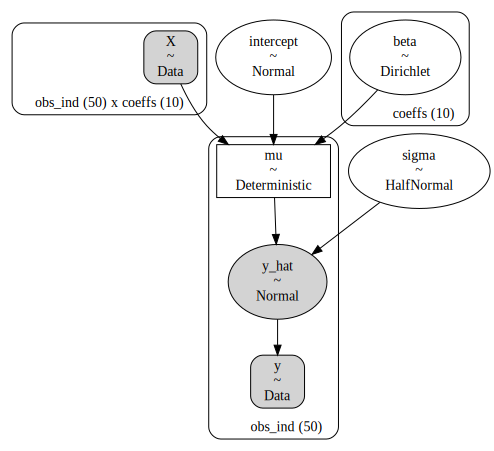

In [15]:
model.to_graphviz()

In [65]:
def print_pm_model_summary(trace, round_to=2):
    """
    Print the model summary with coefficient information analogous to your custom print_coefficients().
    
    This function uses ArviZ to compute summary statistics including the mean and 94% highest density interval (HDI)
    for each parameter.
    """
    # Get a summary DataFrame with a 94% HDI (i.e. quantiles at 3% and 97%)
    summary_df = az.summary(trace, round_to=round_to, hdi_prob=0.94)
    
    header = "=" * 80
    print(header)
    print("PyMC Model Summary")
    print(header)
    
    # We assume the key parameters are 'intercept', 'beta', and 'sigma'.
    # 'beta' will be printed row‐by‐row (e.g., beta[0], beta[1], …) when it is an array.
    
    # Print intercept and sigma if they exist
    for param in ["intercept", "sigma"]:
        if param in summary_df.index:
            row = summary_df.loc[param]
            print(f"{param:<12}: mean = {row['mean']:.{round_to}f}, 94% HDI = "
                  f"[{row['hdi_3%']:.{round_to}f}, {row['hdi_97%']:.{round_to}f}]")
    
    # Now print each beta coefficient. The index names should start with "beta".
    beta_rows = summary_df[summary_df.index.str.startswith("beta")]
    for index, row in beta_rows.iterrows():
        print(f"{index:<12}: mean = {row['mean']:.{round_to}f}, 94% HDI = "
              f"[{row['hdi_3%']:.{round_to}f}, {row['hdi_97%']:.{round_to}f}]")

def calculate_bayesian_r2(trace, y_true, round_to=2):
    """
    Compute a Bayesian R² based on the posterior expected values.
    
    This extracts the posterior samples for the deterministic variable 'mu' (the model prediction)
    and calculates R² by averaging across chains and draws.
    """
    # Extract 'mu' from the inference data. The shape is (chain, draw, obs_ind)
    mu_samples = trace.posterior["mu"].values  
    # Compute the predictive mean across chains and draws (collapsing the first two dimensions)
    mu_mean = mu_samples.mean(axis=(0, 1))
    r2 = r2_score(y_true, mu_mean)
    return round(r2, round_to)

In [66]:
print_pm_model_summary(trace, round_to=2)

PyMC Model Summary
intercept   : mean = -2.20, 94% HDI = [-2.49, -1.94]
sigma       : mean = 0.98, 94% HDI = [0.80, 1.17]
beta[0]     : mean = 0.06, 94% HDI = [0.00, 0.16]
beta[1]     : mean = 0.26, 94% HDI = [0.04, 0.46]
beta[2]     : mean = 0.07, 94% HDI = [0.00, 0.18]
beta[3]     : mean = 0.09, 94% HDI = [0.00, 0.22]
beta[4]     : mean = 0.11, 94% HDI = [0.00, 0.25]
beta[5]     : mean = 0.12, 94% HDI = [0.00, 0.27]
beta[6]     : mean = 0.06, 94% HDI = [0.00, 0.16]
beta[7]     : mean = 0.13, 94% HDI = [0.00, 0.28]
beta[8]     : mean = 0.09, 94% HDI = [0.00, 0.22]
